In [1]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('Entrenamieto_ECI_2020.csv',)

def formateo(x):
    cadena = x.split('/')
    return '{dia:02}/{mes:02}/{ano}'.format(dia=int(cadena[0]), mes=int(cadena[1]),ano=int(cadena[2]))
df['Account_Created_Date'] = df['Account_Created_Date'].apply(formateo)
df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], format='%m/%d/%Y')
df['Planned_Delivery_Start_Date'] = df['Planned_Delivery_Start_Date'].apply(formateo)
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'], format='%m/%d/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  16947 non-null  int64         
 1   Region                              16947 non-null  object        
 2   Territory                           16947 non-null  object        
 3   Pricing, Delivery_Terms_Quote_Appr  16947 non-null  int64         
 4   Pricing, Delivery_Terms_Approved    16947 non-null  int64         
 5   Bureaucratic_Code_0_Approval        16947 non-null  int64         
 6   Bureaucratic_Code_0_Approved        16947 non-null  int64         
 7   Submitted_for_Approval              16947 non-null  int64         
 8   Bureaucratic_Code                   16947 non-null  object        
 9   Account_Created_Date                16947 non-null  datetime64[ns]
 10  Source                

### ¿Puede deducirse alguna nocion de obsolescencia?

In [2]:
df_producto = df[['Stage','Product_Type','Product_Family','Product_Name','Planned_Delivery_Start_Date','Planned_Delivery_End_Date']]
df_producto = df_producto[df_producto['Stage'] == 'Closed Won']
df_familia = df_producto.groupby('Product_Family')['Planned_Delivery_Start_Date'].agg(['min','max']).reset_index()
df_familia['intervalo'] = df_familia['max'] - df_familia['min']
df_familia[df_familia['intervalo'].dt.days < 365]['intervalo'].count()

96

In [3]:
df_familia[df_familia['intervalo'].dt.days > 365*2]['intervalo'].count()

34

Si, se osbserva que de las familias consideradas, la mitad no genera oportunidades exitosas tras
un año de su primera venta. Además solo 20 familias continúan vendiendose tras dos años y medio
desde su publicitación.

In [4]:
df_producto.groupby('Product_Family')['Product_Name'].count().describe()

count    203.000000
mean      46.960591
std      110.781957
min        1.000000
25%        2.000000
50%        8.000000
75%       29.500000
max      919.000000
Name: Product_Name, dtype: float64

### ¿Cuanto es el intervalo promedio de oportunidades por region/territorio?

In [5]:
df_zona = df[['Stage','Region','Territory','Product_Family','Planned_Delivery_Start_Date']]
df_zona_ganada = df_zona[df_zona['Stage'] == 'Closed Won']
df_region = df_zona_ganada.groupby(['Product_Family','Region'])['Planned_Delivery_Start_Date'].agg(['min','max']).reset_index()
df_region['Duracion'] = (df_region['max'] - df_region['min']).dt.days
df_region.reset_index().groupby('Region')['Duracion'].mean().sort_values().to_frame().reset_index()

,Region,Duracion
0,Middle East,72.923077
1,Americas,254.805556
2,APAC,265.125874
3,EMEA,319.415584
4,Japan,511.000000


In [6]:
df_territorio = df_zona_ganada.groupby(['Product_Family','Territory'])['Planned_Delivery_Start_Date'].agg(['min','max']).reset_index()
df_territorio['Duracion'] = (df_region['max'] - df_region['min']).dt.days
df_territorio.reset_index().groupby('Territory')['Duracion'].mean().sort_values().reset_index().dropna()

,Territory,Duracion
0,Turkey,0.000000
1,Malta,0.000000
2,South East Asia,10.000000
3,UAE (Dubai),14.000000
4,Slovenia,63.000000
5,United Kingdom,130.071429
6,Jordan,151.250000
7,Philippines,163.000000
8,Belgium,188.352941
9,Denmark,188.571429


### ¿Cómo es el comportamiento de compra de cada region/territorio?

In [7]:
df_region2 = pd.merge(df_region, df_zona_ganada[['Product_Family','Region','Planned_Delivery_Start_Date']], on=['Product_Family','Region'])
for i in range(0,11):
    df_region2[str(i) + '/10'] = (((df_region2['Planned_Delivery_Start_Date']-df_region2['min']).dt.days)/df_region2['Duracion'] >= i/10)\
    & (((df_region2['Planned_Delivery_Start_Date']-df_region2['min']).dt.days)/df_region2['Duracion'] < (i+1)/10)
    df_region2[str(i) + '/10'] = df_region2[str(i) + '/10'].astype(int)
df_region2 = df_region2.groupby('Region')[['0/10','1/10','2/10','3/10','4/10','5/10','6/10','7/10','8/10','9/10','10/10']].sum()
df_region2['Total'] = df_region2['0/10']+df_region2['1/10']+df_region2['2/10']+df_region2['3/10']+df_region2['4/10']+\
df_region2['5/10']+df_region2['6/10']+df_region2['7/10']+df_region2['8/10']+df_region2['9/10']+df_region2['10/10']
df_region2 = df_region2[['0/10','1/10','2/10','3/10','4/10','5/10','6/10','7/10','8/10','9/10','10/10']]\
.div(df_region2['Total'],axis=0)
df_region2

,0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10
Region,,,,,,,,,,,
APAC,0.125882,0.117743,0.117200,0.102008,0.105806,0.122084,0.083017,0.065111,0.059685,0.038524,0.062941
Americas,0.108047,0.113675,0.097918,0.090602,0.123804,0.134496,0.078784,0.082724,0.086663,0.047833,0.035453
EMEA,0.137495,0.111791,0.101591,0.118727,0.119135,0.109343,0.082007,0.077927,0.066911,0.051816,0.023256
Japan,0.106820,0.099276,0.107121,0.140616,0.124019,0.123416,0.113156,0.079964,0.060652,0.027158,0.017803
Middle East,0.400000,0.057143,0.057143,0.000000,0.028571,0.057143,0.000000,0.057143,0.028571,0.000000,0.314286


Text(0, 0.5, 'Ventas %')

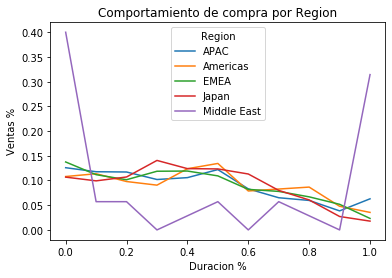

In [8]:
a = df_region2.T
a.index = [0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10]
a.plot()
plt.title("Comportamiento de compra por Region")
plt.xlabel("Duracion %")
plt.ylabel("Ventas %")

In [9]:
df_territorio2 = pd.merge(df_territorio, df_zona_ganada[['Product_Family','Territory','Planned_Delivery_Start_Date']], on=['Product_Family','Territory'])
for i in range(0,11):
    df_territorio2[str(i) + '/10'] = (((df_territorio2['Planned_Delivery_Start_Date']-df_territorio2['min']).dt.days)/df_territorio2['Duracion'] >= i/10)\
    & (((df_territorio2['Planned_Delivery_Start_Date']-df_territorio2['min']).dt.days)/df_territorio2['Duracion'] < (i+1)/10)
    df_territorio2[str(i) + '/10'] = df_territorio2[str(i) + '/10'].astype(int)
df_territorio2 = df_territorio2.groupby('Territory')[['0/10','1/10','2/10','3/10','4/10','5/10','6/10','7/10','8/10','9/10','10/10']].sum()
df_territorio2['Total'] = df_territorio2['0/10']+df_territorio2['1/10']+df_territorio2['2/10']+df_territorio2['3/10']+df_territorio2['4/10']+\
df_territorio2['5/10']+df_territorio2['6/10']+df_territorio2['7/10']+df_territorio2['8/10']+df_territorio2['9/10']+df_territorio2['10/10']
df_territorio2 = df_territorio2[['0/10','1/10','2/10','3/10','4/10','5/10','6/10','7/10','8/10','9/10','10/10']]\
.div(df_territorio2['Total'],axis=0)
df_territorio2.dropna()

,0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10
Territory,,,,,,,,,,,
Australia,0.218750,0.131250,0.081250,0.056250,0.087500,0.125000,0.087500,0.112500,0.000000,0.037500,0.062500
Austria,0.288136,0.169492,0.084746,0.101695,0.084746,0.101695,0.067797,0.016949,0.067797,0.016949,0.000000
Belgium,0.480769,0.076923,0.153846,0.173077,0.057692,0.000000,0.019231,0.000000,0.019231,0.019231,0.000000
Canada,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Carribean,0.400000,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000
Central US,0.476190,0.238095,0.095238,0.095238,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
China (PRC),0.250000,0.150000,0.100000,0.150000,0.000000,0.100000,0.000000,0.050000,0.000000,0.100000,0.100000
Cyprus,0.714286,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
Denmark,0.750000,0.125000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0, 0.5, 'Ventas %')

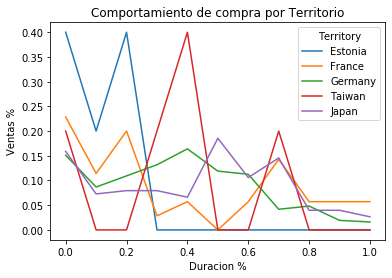

In [10]:
b = df_territorio2.T
b.index = [0/10,1/10,2/10,3/10,4/10,5/10,6/10,7/10,8/10,9/10,10/10]
b[['Estonia','France','Germany','Taiwan','Japan']].plot()
plt.title("Comportamiento de compra por Territorio")
plt.xlabel("Duracion %")
plt.ylabel("Ventas %")

### ¿Cuales son los clientes con mayor porcentaje de éxito?

In [11]:
df_nombre = df[['Stage','Account_Type','Account_Name','Account_Created_Date']]
df_nombre = df_nombre[(df_nombre['Stage'] == 'Closed Won') | (df_nombre['Stage'] == 'Closed Lost')]
df_por_nombre = df_nombre.groupby('Account_Name')['Stage'].count()
promedio_oportunidades = df_por_nombre.mean()
df_por_nombre = df_por_nombre.to_frame().reset_index()
df_por_nombre = df_por_nombre[df_por_nombre['Stage'] > promedio_oportunidades]
df_por_nombre.columns = ['Account_Name','Total Count']
df_nombre_mejores = df_por_nombre.merge(df_nombre, left_on='Account_Name',right_on='Account_Name',how='left')
def ha_ganado(x):
    if(x == 'Closed Won'):
        return 1
    return 0
df_nombre_mejores['Stage'] = df_nombre_mejores['Stage'].apply(ha_ganado)
mejores_50 = df_nombre_mejores.groupby('Account_Name')['Stage'].mean().nlargest(50).reset_index()
mejores_50.columns = ['Account_Name','Porcentaje_Exito']
mejores_50

,Account_Name,Porcentaje_Exito
0,Account_Name_1240,1.000000
1,Account_Name_147,1.000000
2,Account_Name_1542,1.000000
3,Account_Name_1774,1.000000
4,Account_Name_1784,1.000000
5,Account_Name_231,1.000000
6,Account_Name_993,1.000000
7,Account_Name_591,0.976744
8,Account_Name_1468,0.976190
9,Account_Name_1904,0.967742


### ¿Cuales son los clientes con mayores casos ganados?

In [12]:
df_nombre_mejores.groupby('Account_Name')['Stage'].sum().nlargest(50).reset_index()

,Account_Name,Stage
0,Account_Name_1888,1018
1,Account_Name_1836,795
2,Account_Name_25,539
3,Account_Name_1991,520
4,Account_Name_1508,323
5,Account_Name_1440,267
6,Account_Name_263,205
7,Account_Name_1642,204
8,Account_Name_931,203
9,Account_Name_533,190


### ¿Hay alguna tendencia en la antiguedad del cliente?

In [13]:
df_nombre_mejores.groupby(df_nombre_mejores['Account_Created_Date'].dt.year)['Stage'].mean()

Account_Created_Date
2013    0.734147
2014    0.540954
2015    0.605035
2016    0.640094
2017    0.559250
2018    0.417266
Name: Stage, dtype: float64

Los clientes con mayor antiguedad efectivamente presentan un mayor porcentaje de casos ganados.
Sin embargo no es una relación lineal.

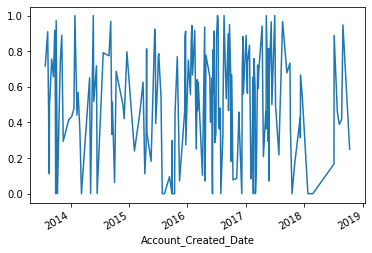

In [14]:
df_nombre_mejores.groupby(df_nombre_mejores['Account_Created_Date'])['Stage'].mean().plot()